# Imports

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 40)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import metrics

import feather
import os
import time

In [2]:
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences

ModuleNotFoundError: No module named 'keras'

## Data

train_limited represents a subset of the entire training set, sampled to reflect the distribution of phases found in the test set

In [4]:
limited_path = 'train_limited.feather'

In [5]:
train_limited = feather.read_dataframe(limited_path)

train_labels contains the final turbidity for each unique process_id

In [6]:
label_path = 'train_labels.feather'

In [7]:
train_labels = feather.read_dataframe(label_path)

# Feature Engineering

Collect each process into a single sequence

Pad entries so they are uniform in length

So, in essence we want a three-dimension matrix of shape (m, T, f) - where m is the number of unique processes, T is the number of time-sequences, and f is the number of features

In order to do that, I think I'll need to group the data by the process_id, and then somehow split each group into it's own 2-dimensional matrix

ts_cols are the columns that seemed most valuable to keep (based on the Benchmark Notebook)

In [8]:
ts_cols = [
    'timestamp',
    'process_id',
    'pipeline',
    'phase',
    'object_id',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
]

train_converted just converts any non-numeric values into numbers (which is basically just the pipeline number)

In [9]:
train_converted = pd.get_dummies(train_limited[ts_cols])

In [11]:
train_converted.process_id.nunique()

4902

## Separate matrices by column

Plan: Create m different matrices of size (? x f) by looping over the process_id and separating them into different tensors

## Step 1: Figure out the dimensions of each process_id

 we know each process has a set number of features (columns), but they vary by number of rows (a.k.a. number of timestamps)

#### A. Get a list of all the process_ids

In [12]:
ids = train_converted.process_id.unique()

In [39]:
print(len(ids))

4902


#### B. Inspect some example process_ids

In [16]:
tc_0 = train_converted[train_converted.process_id == ids[0]]

In [18]:
tc_0.head()

,timestamp,process_id,object_id,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,return_flow,tank_level_pre_rinse,tank_level_caustic,tank_level_acid,tank_level_clean_water,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,pipeline_L1,pipeline_L10,pipeline_L11,pipeline_L12,pipeline_L2,pipeline_L3,pipeline_L4,pipeline_L6,pipeline_L7,pipeline_L8,pipeline_L9,phase_acid,phase_caustic,phase_intermediate_rinse,phase_pre_rinse
0,2018-04-15 04:20:47,20001,405,8550.348,0.615451,18.044704,4.990765,0.177228,15776.9100,55.499672,41.555992,44.026875,49.474102,32.385708,83.036750,73.03241,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,2018-04-15 04:20:49,20001,405,11364.294,0.654297,18.229168,3.749680,0.122975,13241.4640,55.487920,41.624170,44.045685,49.457645,32.385708,83.015045,73.03241,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,2018-04-15 04:20:51,20001,405,12174.479,0.699870,18.395544,2.783954,0.387008,10698.7850,55.476166,41.638275,44.045685,49.462350,32.385708,83.015045,73.03241,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,2018-04-15 04:20:53,20001,405,13436.776,0.761502,18.583622,1.769353,0.213397,8007.8125,55.471466,41.647675,44.048030,49.462350,32.385708,83.036750,73.03241,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,2018-04-15 04:20:55,20001,405,13776.766,0.837240,18.627026,0.904020,0.148293,6004.0510,55.459705,41.654730,44.048030,49.462350,32.385708,83.015045,73.03241,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [19]:
tc_1 = train_converted[train_converted.process_id == ids[1]]

In [20]:
tc_1.shape[1]

31

Conclusion: They have the same number of columns (31), but the number of rows varies

#### C. Get the row-counts for all the process_ids

In [21]:
rows = []
for i in ids:
    process = train_converted[train_converted.process_id == i]
    rows.append(process.shape[0])

Alright, now we have a list of all the row-counts  
Let's double check the dimensions of the list (it should have 4902 entries, the number of distinct process_ids)

In [26]:
len(rows)

4902

Bingo!

#### Analyze the row-counts

Now let's visualize these lengths, get a sense for how they're distributed

{'whiskers': [<matplotlib.lines.Line2D at 0x7f87f56dec18>,
 'caps': [<matplotlib.lines.Line2D at 0x7f87f56deeb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f87f56de518>],
 'medians': [<matplotlib.lines.Line2D at 0x7f87f56f3978>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f87f56f3cc0>],
 'means': []}

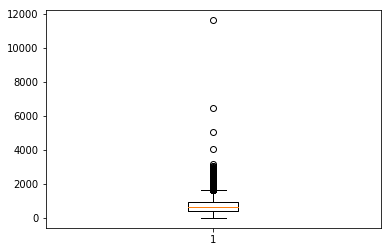

In [27]:
plt.boxplot(rows)

Okay, so, median somewhere around a 1000, deep right-skew

In [28]:
np.max(rows)

11607

The max is 11607, which means each process_id needs to be 11607 rows longs... that's a lot of padding. Let's save that to a global variable

### Padding function

Testing out ways to add zeros to the end of an array - part of Rinse_over_Run 

This function adds a row to each channel


In [29]:
def add_rows(array, row):
    # create a new array in which the updated channels will be added 
    new_array = np.zeros((array.shape[0], array.shape[1]+1, array.shape[2]))
    
    # loop over every channel in the previous array
    for i in range(len(array)):
        # check the size of the arrays - new array should have one additional row compared to the array
        print("new array shape is {}".format(new_array[i].shape))
        print("old array shape is {}".format(array[i].shape))
        
        # the row length should match the number of array columns
        print("row shape is {}".format(row.shape))
        
        # create a new array which has the row appended to it
        appended = np.append(array[i], row)
        
        # the appended array will be one long vector
        print("appended shape is {}".format(appended.shape))
        
        # reshape the array with the original number of columns, extending the number of rows as necessary
        appended = np.reshape(appended, (-1, array.shape[2]))
        print("reshaped shape is {}".format(appended.shape))
        print("\n")
        
        # update the new_array with this appended array
        new_array[i] = appended
       
    # return the new_array
    return new_array

The above function adds a single row to each channel, but I need to add an arbitrary number of rows  
Let's see if I can modify the append section of the loop

In [30]:
"""
to create an update matrix, I needed to check the rules for broadcasting
I don't know the method for converting a 1D array into a multi-dimensional one
so I just multiplied it by an appropriately sized array of ones
"""

np.ones((2, 37)) * np.arange(1, 38)

array([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.]])

In [31]:
"""
This function takes the same array and row inputs as the previous one, but it also takes a 'count' parameter which
dictates how many times the row will be repeated at the end of the array, e.g. if count is 5, the array will be 
padded 5 times with the specified row
"""


def add_arbitrary_rows(array, row, count):
    # the new empty array will have an arbitrary number of columns in each channel, dictated by the count parameter
    new_array = np.zeros((array.shape[0], array.shape[1]+count, array.shape[2]))
    
    # if count is greater than 1, appending a matrix is easier than appending a row
    update_matrix = np.ones((count, array.shape[2])) * row
    
    for i in range(len(array)):
        print("new array shape is {}".format(new_array[i].shape))
        print("old array shape is {}".format(array[i].shape))
        print("update_matrix is {}".format(update_matrix.shape))
        
        appended = np.append(array[i], update_matrix)
        
        print("appended shape is {}".format(appended.shape))
        
        appended = np.reshape(appended, (-1, array.shape[2]))
        print("reshaped shape is {}".format(appended.shape))
        print("\n")
        
        # update the new_array with this appended array
        new_array[i] = appended
    
    return new_array

So, now I can add an arbitrary number of rows to a channel in a matrix  
  
I think I can use this to process the Rinse_over_Run data  
I'll loop over each process_id, and then use the add_arbitrary_rows function to add rows until it's equal to the size of the longest process

#### Padding Test

Let's test it out - I should be able to isolate a single process_id from the train_converted data, and then add an arbitrary number of rows to it

In [39]:
# convert the dataframe into an array
tc_0_array = tc_0.values

In [69]:
tc_0_array.shape[0]

1425

In [45]:
# define a row of zeros to be added
zero_row = np.zeros((1, 31))

In [47]:
# This won't work because the function assumes a 3D array, while the tc_0_array is only 2D
add_arbitrary_rows(tc_0_array, zero_row, 1)

IndexError: tuple index out of range

I need a function that will add an arbitrary number of rows to a 2D array

In [58]:
def add_rows_2d(array, row, count):
    new_array = np.zeros((array.shape[0] + 1, array.shape[1]))
    update_array = np.ones((count, array.shape[1])) * row
    appended = np.append(array, update_array)
    new_array = np.reshape(appended, (-1, array.shape[1]))
    return new_array

In [61]:
tc_0_updated= add_rows_2d(tc_0_array, zero_row, 2)

In [66]:
np.shape(tc_0_updated)

(1427, 31)

Okay, so now I can loop over all the arrays and update them to have the correct number of rows (np.max(rows))

In [72]:
tc_0_maxLen = add_rows_2d(tc_0_array, zero_row, maxLen-tc_0_array.shape[0])

In [73]:
tc_0_maxLen.shape

(11607, 31)

## Actually Doing The Thing

Convert the train_converted Dataframe into a numpy array

In [ ]:
tc_array = train_converted.values